# Using Age, Cholestorol Levels, and Blood Pressure to assess prognosis of heart disease.

Ethan D'Souza, Emily Zhang, Alice An, Vivaan Wadhwa

# 1. Introduction

Heart disease is a leading cause of death between all groups of people in the United States. This disease occurs when the diameter of arteries to the heart becomes decreased and the blood flow is reduced as stated by the Centers for Disease Control and Prevention (CDC). This causes heart attacks, among many other consequences. Both genetic and environmental circumstances contribute to the possibility of developing the condition. 

Multiple risk factors affect the likelihood of heart disease such as age, blood pressure and cholesterol. Individuals of older age have a higher chance of being diagnosed with heart disease (Rogers et al. 2019). According to the CDC, high cholesterol levels result in plaque formation within blood vessels, causing them to become stiff and narrower. This suppresses blood circulation, leading to irregular heart beats, heart attacks, and ultimately death. Cholesterol levels of 240+ mg/dL (milligrams per deciliter) is considered to be high. Furthermore, high blood pressure causes arteries to lose their elasticity which lowers blood circulation to the heart. Where high systolic blood pressure is 240+ mm Hg (millimeter of mercury in arteries when the heart is beating) and diastolic blood pressure is 90+ mm Hg (millimeter of mercury in arteries when the heart is resting) according to the CDC. 

Using the “Heart Disease Data Set” provided to us by UCI, we used data from Cleveland to help answer our question. Within the dataset, we used the following three predictors: age, resting blood pressure and cholesterol level to anticipate angiographic disease status, also presented in the data set. Angiographic disease status is a binary identification, where if the blood vessels are narrowed more than 50%, the patient would be defined to have the disease. Through comparisons, these data points would assist in anticipating a prognosis of different risk levels for a patient who could provide the data of the 3 aspects we observed.

Ultimately, our goal is to answer the question “can age, resting blood pressure, and cholesterol accurately predict angiographic disease status?” 


# 2. Preliminary Data Analysis

For starters, we load the necessary packages needed to perform the analysis. 

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The data is first loaded from the web. We tidied the data, and renamed the columns for better readability. We ended up with a final tibble containing the four variables that are relevant to our question. Here, likelihood is our classification variable with type “factor”, and age, resting blood pressure, and cholesterol are predictor variables all with type “double”. 

In [2]:
raw_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
raw_data <- read_csv(raw_data_url,col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang" ,"oldpeak" ,"slope" ,"ca" ,"thal" ,"num"))
tidy_data <- raw_data |>
                select(age,trestbps,chol,num) |>
                    rename("age" = "age",
                           "resting.blood.pressure" = "trestbps" ,
                           "cholesterol" = "chol",
                           "heart.disease" = "num") |>
                    mutate(heart.disease = case_when(heart.disease == 0 ~ "Absent",
                                                  heart.disease != 0 ~ "Present")) |>
                    mutate(heart.disease = as.factor(heart.disease))
head(tidy_data)
                

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,resting.blood.pressure,cholesterol,heart.disease
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,Absent
67,160,286,Present
67,120,229,Present
37,130,250,Absent
41,130,204,Absent
56,120,236,Absent


We set the seed so that all the code below is reproducible. The data is then split into 75% training data, and 25% testing data. The training data will be used to train our model and then the testing data will be used to check the accuracy of our model. 

In [3]:
set.seed(1) ## DO NOT CHANGE

## splitting into training and testing data
data_split <- initial_split(tidy_data, prop = 0.75, strata = heart.disease)
data_train <- training(data_split)
data_test <- testing(data_split)

The data is summarized into two tables: 
- number of observations of “present” and "absent"
- average values of all predictors for observations for "absent" and "present"


In [4]:
##Number of observations of "absent" and "present"
data_count <- data_train |> 
        group_by(heart.disease) |>
        summarize(count = n())
data_count

heart.disease,count
<fct>,<int>
Absent,123
Present,104


In [5]:
##Average Values of all predictors for "absent" and "present"

data_mean <- data_train |>
        group_by(heart.disease) |>
        summarize(across(age:cholesterol, mean)) |>
         rename("mean.age" = "age",
                           "mean.resting.blood.pressure" = "resting.blood.pressure" ,
                           "mean.cholesterol" = "cholesterol") 

data_mean

heart.disease,mean.age,mean.resting.blood.pressure,mean.cholesterol
<fct>,<dbl>,<dbl>,<dbl>
Absent,52.96748,130.4553,243.9106
Present,57.23077,135.5096,250.5673


## Visualizations

Created a scatterplot of Resting Blood Pressure in mm of Mercury(Hg) against Age of the patient, coloured by likelihood. After age 50 there seems to be more individuals with heart disease present than without and the average Resting Blood Pressure increases.  

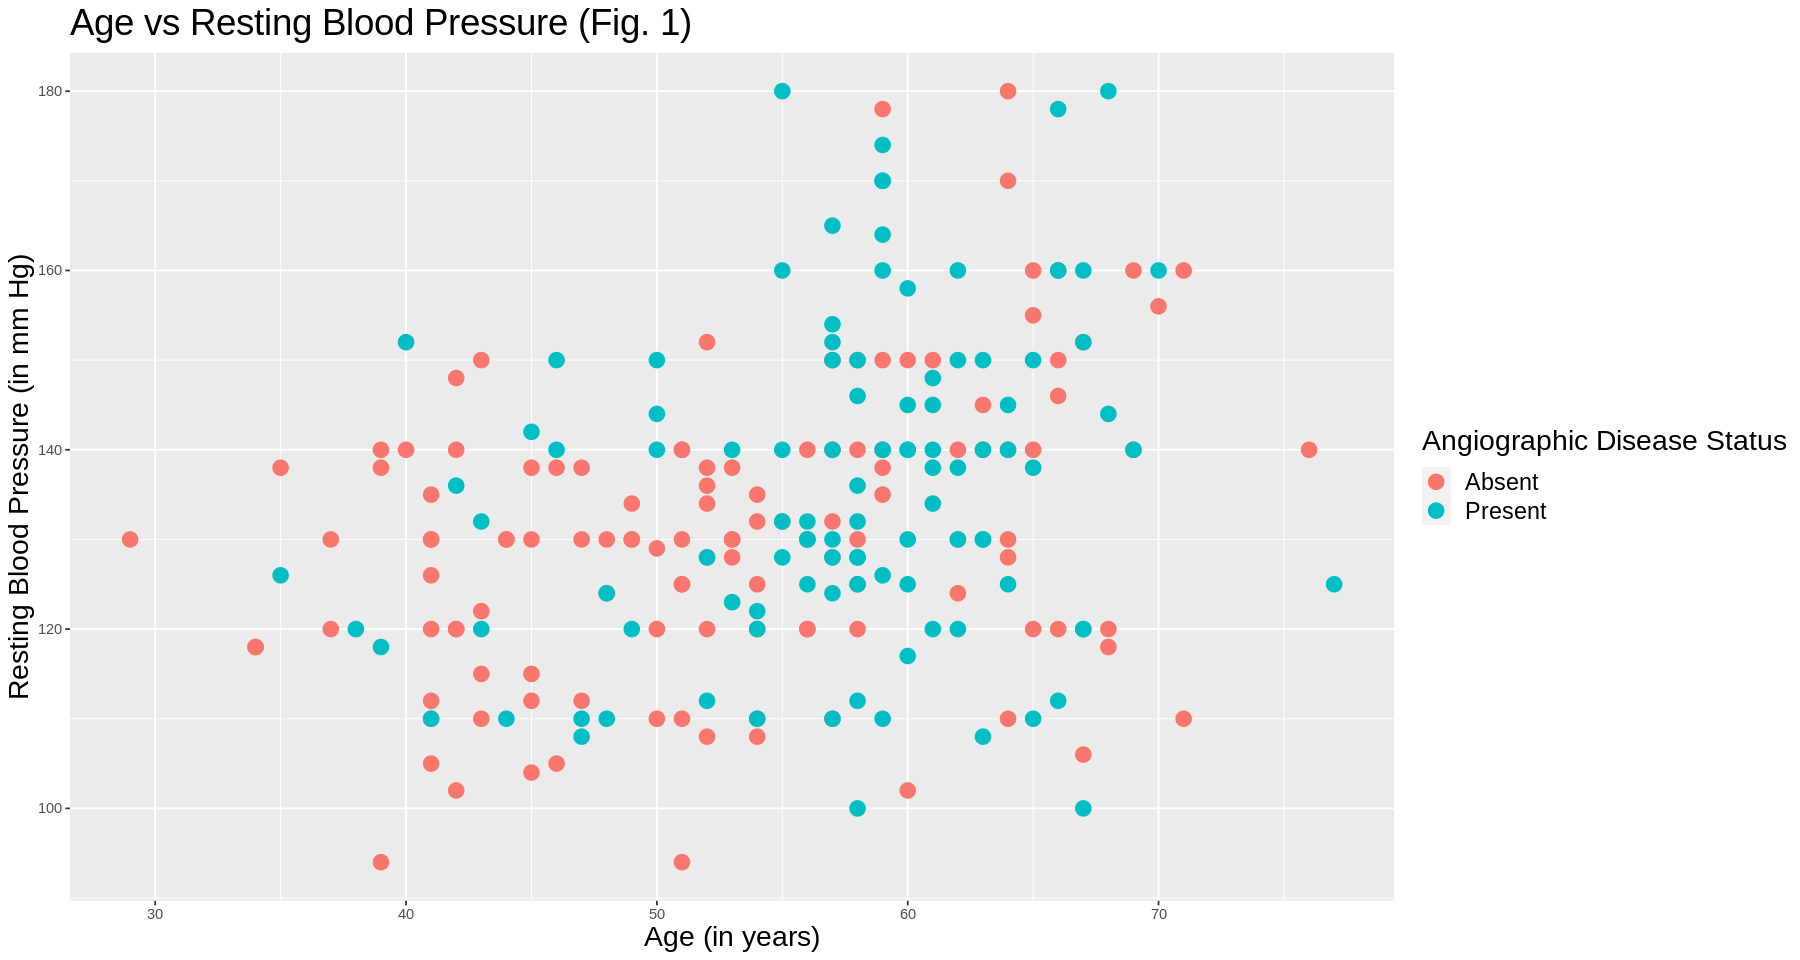

In [6]:
##Age vs Blood Pressure, coloured by likelihood

options(repr.plot.width=15, repr.plot.height=8)
age_v_bp_plot <- data_train |>
                ggplot(aes(x = age, y = resting.blood.pressure, color = heart.disease)) +
                geom_point(size = 4) +
                xlab("Age (in years)") +
                ylab("Resting Blood Pressure (in mm Hg)") +
                labs(color = "Angiographic Disease Status", shape = "liki") +
                ggtitle("Age vs Resting Blood Pressure (Fig. 1)") + 
                theme(plot.title = element_text(size=22),
                      axis.title = element_text(size=17),
                      legend.title = element_text(size = 17),
                      legend.text = element_text(size = 14))

age_v_bp_plot

Created a scatterplot of Cholesterol Level in mg/dl against Age of the patient, coloured by likelihood. Cholesterol level seems to increase on average as age increases, and above the age of 50, the angiographic disease status increases significantly.

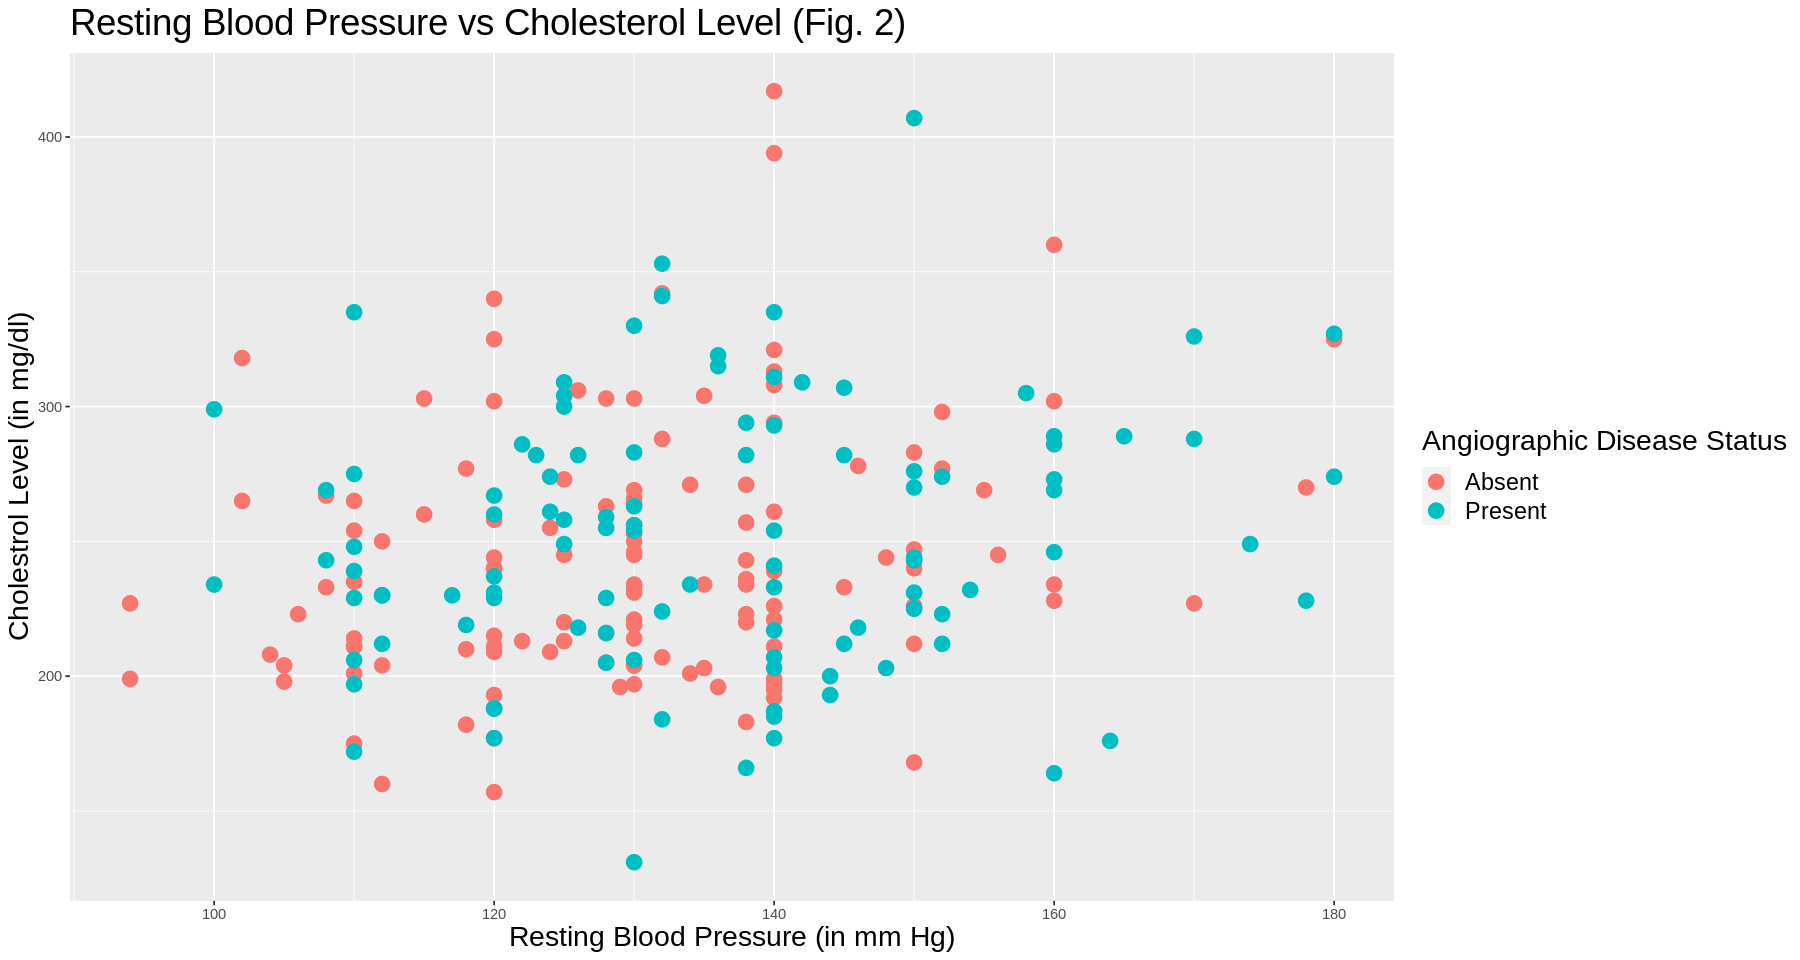

In [7]:
##blood pressure vs Cholestrol Level, coloured by likelihood

bp_v_chol_plot <- data_train |>
                ggplot(aes(x = resting.blood.pressure, y = cholesterol, color = heart.disease)) +
                geom_point(size = 4) +
                xlab("Resting Blood Pressure (in mm Hg)") +
                ylab("Cholestrol Level (in mg/dl)") +
                labs(color = "Angiographic Disease Status") +
                ggtitle("Resting Blood Pressure vs Cholesterol Level (Fig. 2)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))

bp_v_chol_plot

Below is a scatterplot illustrating the relationship between cholestrol level and blood pressure, and whether or not that affects the angiographic disease status. From the graph, we saw no relationship as there was an even distribution of points between the cholesterol and blood pressure. 


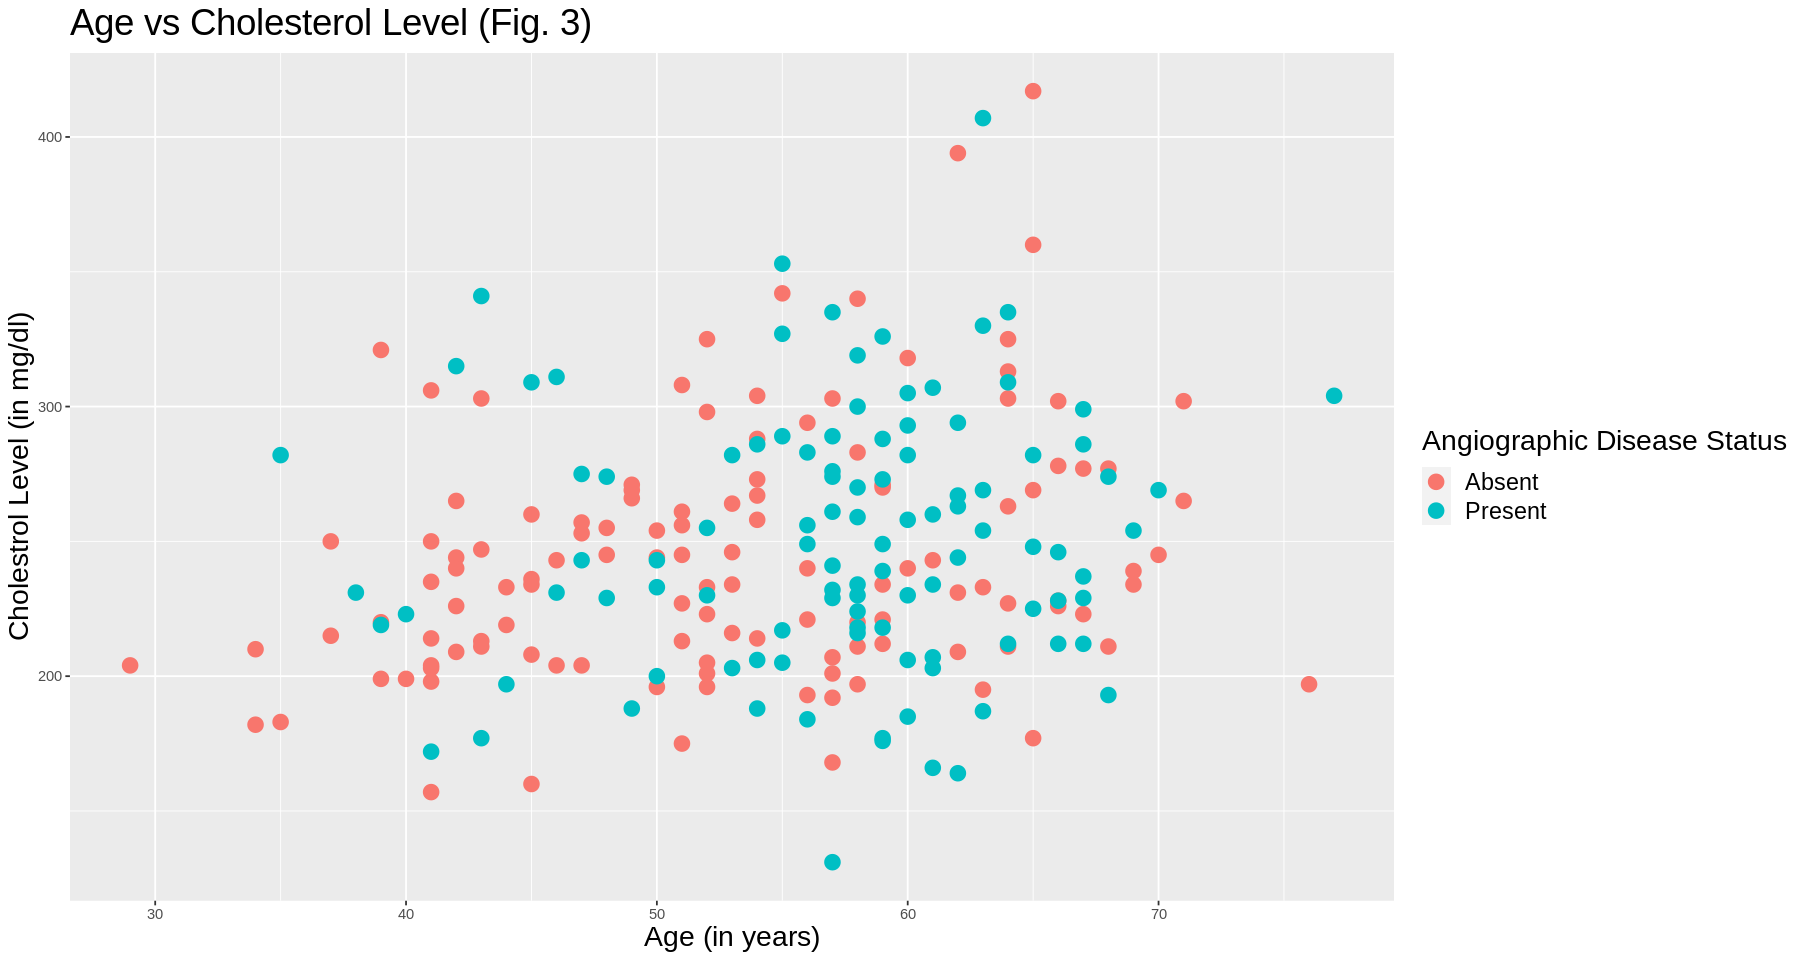

In [8]:
##Age vs Cholestrol Level, coloured by likelihood

age_v_chol_plot <- data_train |>
                ggplot(aes(x = age, y = cholesterol, color = heart.disease)) +
                geom_point(size = 4) +
                xlab("Age (in years)") +
                ylab("Cholestrol Level (in mg/dl)") +
                labs(color = "Angiographic Disease Status") +
                ggtitle("Age vs Cholesterol Level (Fig. 3)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))

age_v_chol_plot


# 3. KNN Classification Model

We will be trying to accurately predict the **Angiographi Disease Status** of a patient using the Predictors mentioned above.

## Finding best $k$-value

The Heart Disease data from Cleveland has already been wrangled and split. We will use the training data stored in `data_train` to find the best $k$-value for our model.

In [9]:
set.seed(1) #DO NOT CHANGE

# Performing Standardization 
cleveland_recipe <- recipe(heart.disease ~ age + cholesterol + resting.blood.pressure,
                           data = data_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# K-nearest neighbour model specification
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
cleveland_vfold <- vfold_cv(data_train, v = 5, strata = heart.disease)

gridvals <- tibble(neighbors = c(1:100))



In [10]:
# Creating a workflow
knn_results <- workflow() |>
      add_recipe(cleveland_recipe) |>
      add_model(knn_spec_tune) |>
      tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
# Collect metrics, filter for accuracy
      collect_metrics() |>
      filter(.metric == "accuracy")

k_table <- knn_results |>
           select(neighbors, mean)

best_k <- k_table |>      
          arrange(desc(mean)) |>
          slice(1) |>
          pull(neighbors)

best_k

[1] 31

Looking at the results, it would seem that $k$ = 31 is a good value but we will plot accuracy against $k$-value to see if this accuracy is constant arounf $k$ = 31

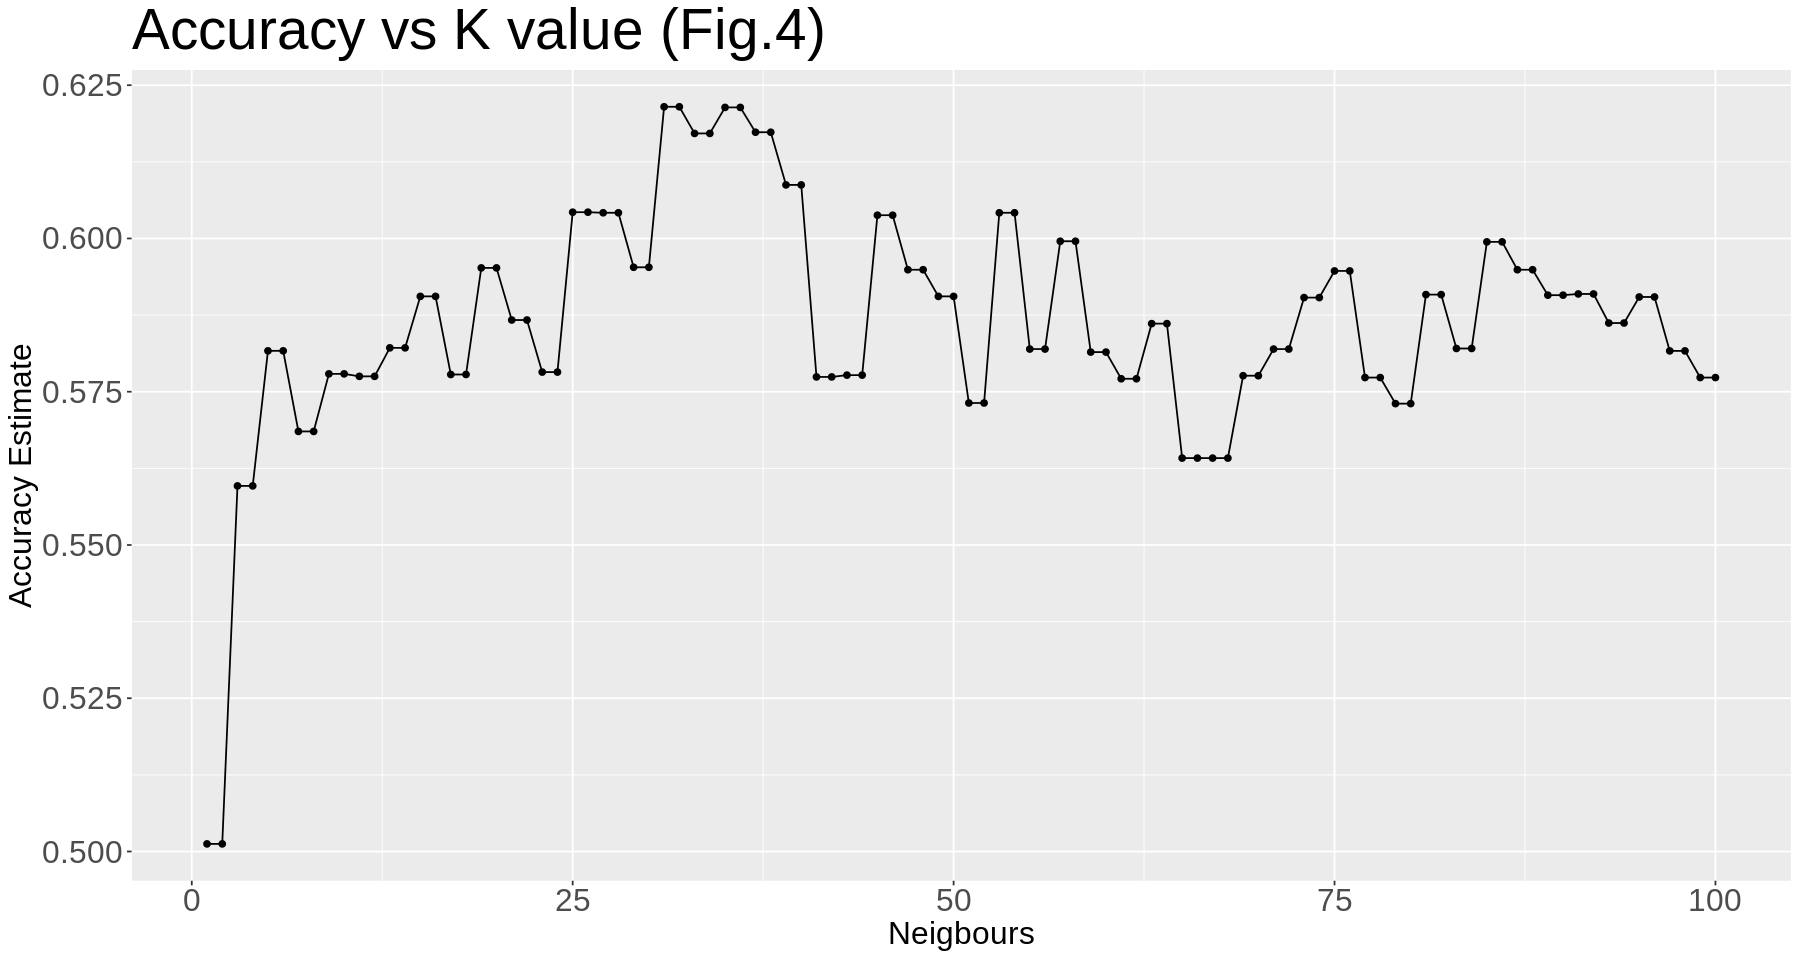

In [11]:
# plotting graph

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        labs(x = "Neigbours", y = "Accuracy Estimate") +
                        ggtitle("Accuracy vs K value (Fig.4)") +
                        theme(plot.title = element_text(size=34)) + 
                        theme(axis.text = element_text(size = 19)) +
                        theme(axis.title = element_text(size = 19))

cross_val_plot

From our analysis above, we can see that the best $k$-value is 31. From here on, we will remake our model with k = 31.

## Remaking model with best $k$-value

In [20]:
set.seed(1) #DO NOT CHANGE
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 27) |>
        set_engine("kknn") |>
        set_mode("classification")

knn_fit <- workflow() |>
        add_recipe(cleveland_recipe) |>
        add_model(knn_spec) |>
        fit(data = data_train)

In [21]:
plot <- knn_predictions |>
    mutate(prediction = case_when(heart.disease == "Absent" & .pred_class == "Absent" ~ "Absent",
                            heart.disease == "Present" & .pred_class == "Present" ~ "Present",
                            heart.disease == "Present" & .pred_class == "Absent" ~ "Present predicted as Absent",
                            heart.disease == "Absent" & .pred_class == "Present" ~ "Absent predicted as Present"),
            prediction = as.factor(prediction))
head(plot)


.pred_class,age,resting.blood.pressure,cholesterol,heart.disease,prediction
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Present,56,120,236,Absent,Absent predicted as Present
Present,62,140,268,Present,Present
Present,57,120,354,Absent,Absent predicted as Present
Absent,44,120,263,Absent,Absent
Present,52,172,199,Absent,Absent predicted as Present
Absent,54,140,239,Absent,Absent


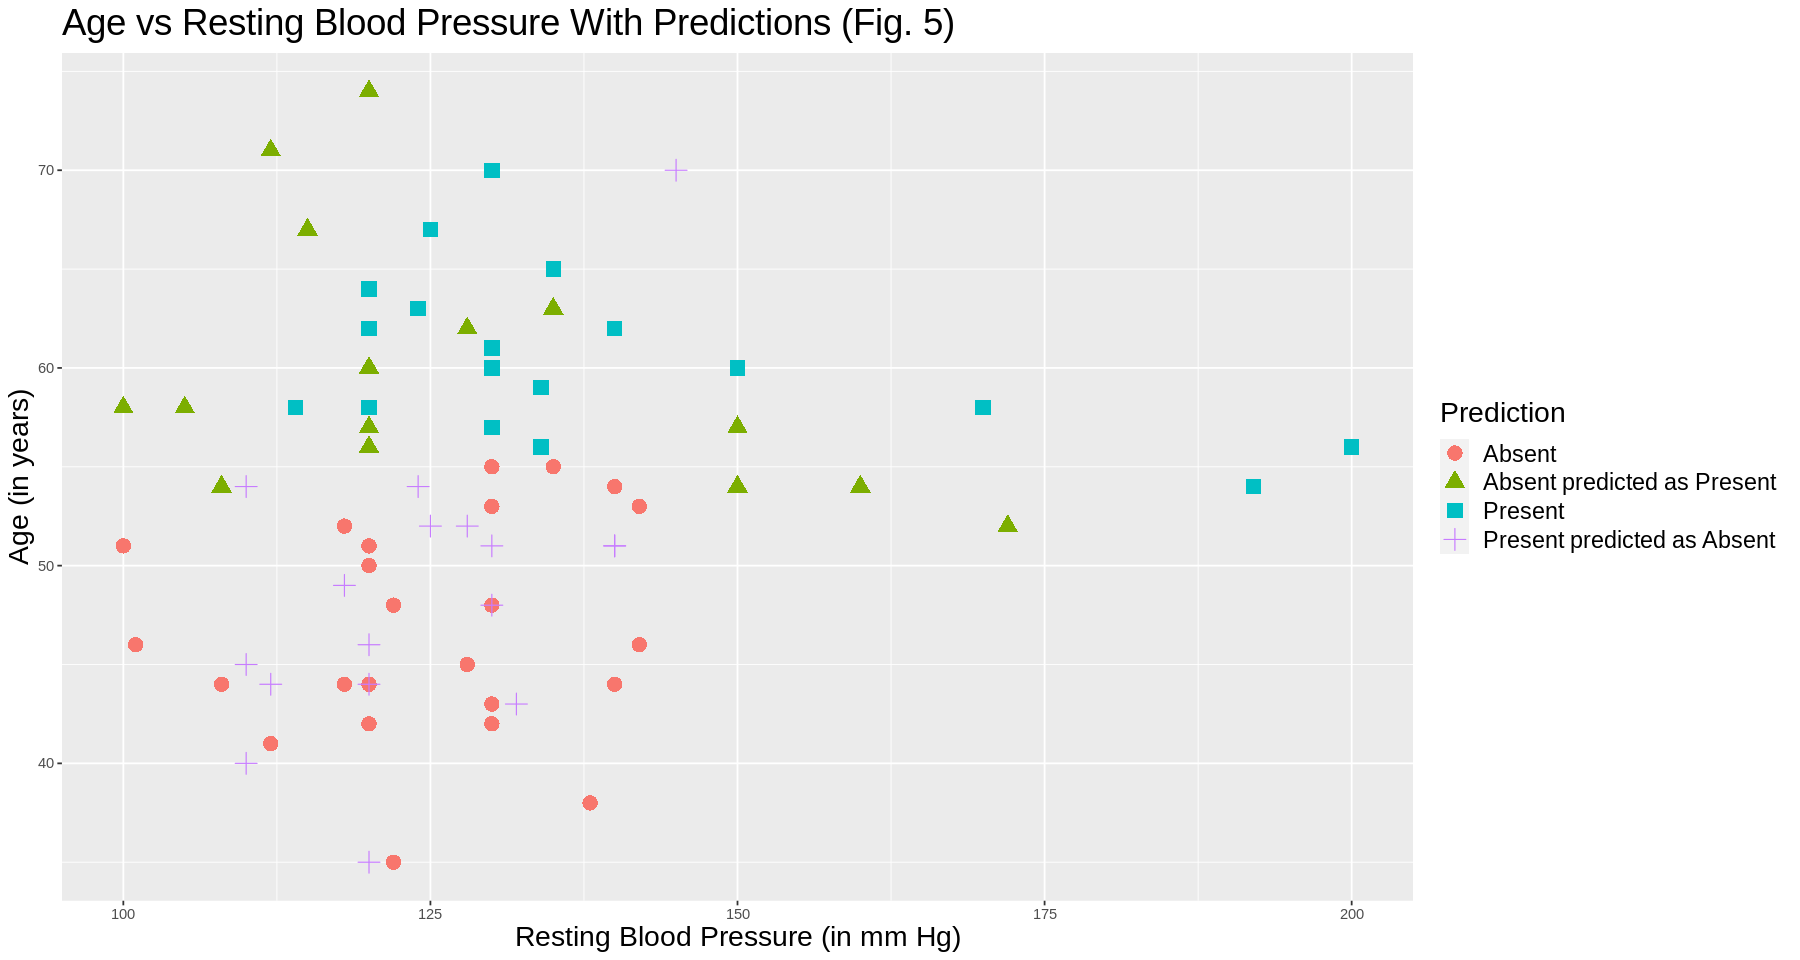

In [35]:
age_v_rbp_wrong_preds <- ggplot(plot, aes(x = resting.blood.pressure, y = age, colour = prediction, shape = prediction)) +
    geom_point(size = 4) + 
    xlab("Resting Blood Pressure (in mm Hg)") +
                ylab("Age (in years)") +
                labs(color = "Prediction", shape = "Prediction") +
                ggtitle("Age vs Resting Blood Pressure With Predictions (Fig. 5)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))
age_v_rbp_wrong_preds


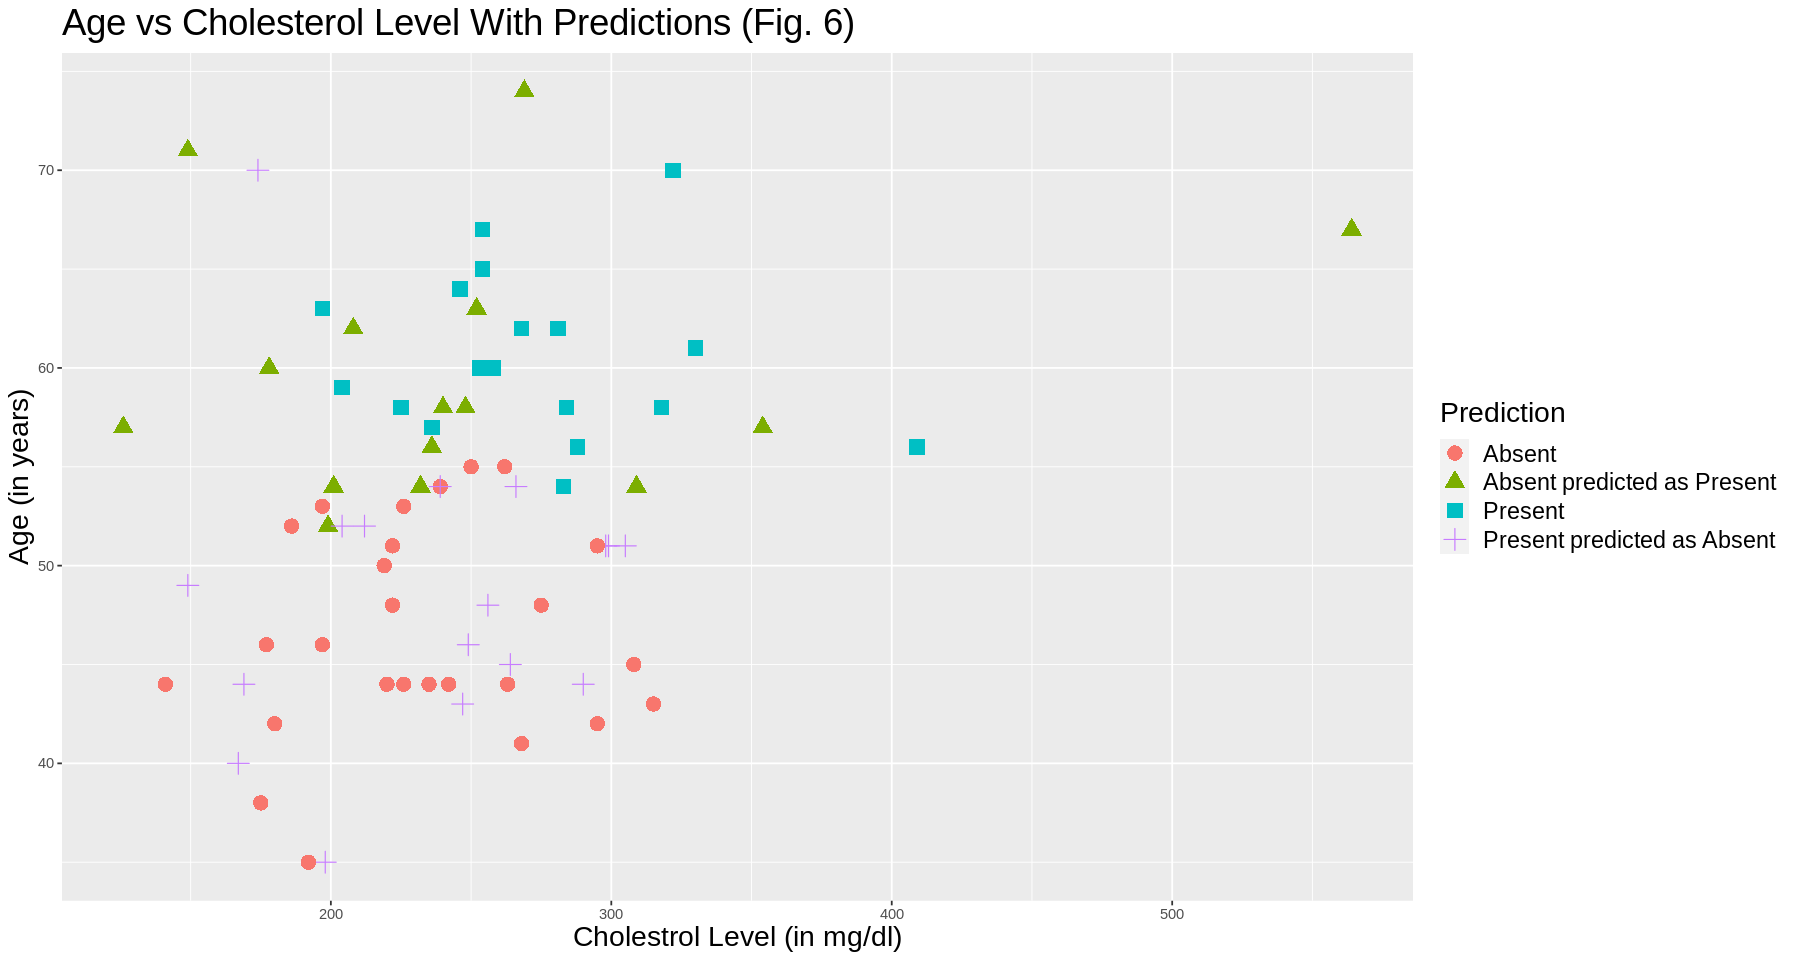

In [36]:
age_v_chol_wrong_preds <- ggplot(plot, aes(x = cholesterol, y = age, colour = prediction, shape = prediction)) +
    geom_point(size = 4) + 
     xlab("Cholestrol Level (in mg/dl)") +
                ylab("Age (in years)") +
                labs(color = "Prediction", shape = "Prediction") +
                ggtitle("Age vs Cholesterol Level With Predictions (Fig. 6)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))
age_v_chol_wrong_preds


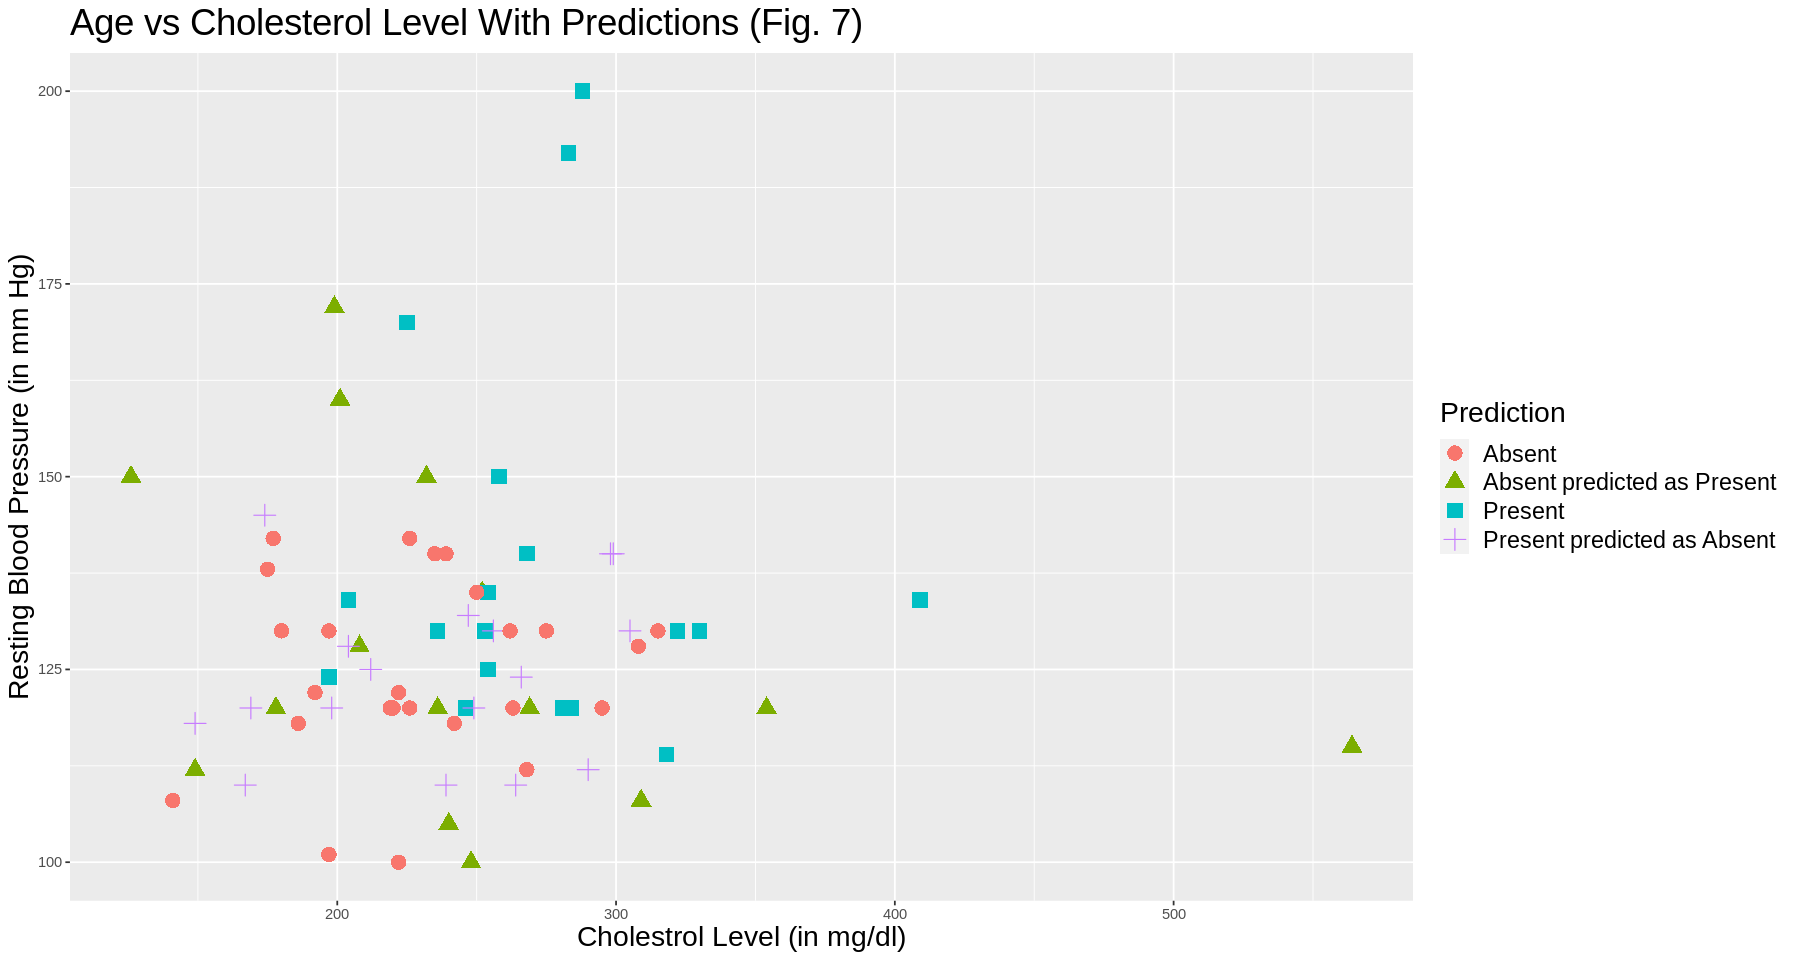

In [39]:
rbp_v_chol_wrong_preds <- ggplot(plot, aes(x = cholesterol, y = resting.blood.pressure, colour = prediction, shape = prediction)) +
    geom_point(size = 4) + 
    xlab("Cholestrol Level (in mg/dl)") +
                ylab("Resting Blood Pressure (in mm Hg)") +
                labs(color = "Prediction", shape = "Prediction") +
                ggtitle("Age vs Cholesterol Level With Predictions (Fig. 7)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))
rbp_v_chol_wrong_preds


## Acuracy of the Model using Testing Data

Now that we have completed making our model, we will test its accuracy using our testing dataset. We will compute the Angiographic Disease Status for the observations in the testing dataset and compare them with the actual values.

In [25]:
knn_predictions <-
        predict(knn_fit, data_test) |>
        bind_cols(data_test)

#visualize the accuracy of the classifier
knn_metrics <- knn_predictions |>
        metrics(truth = heart.disease, estimate = .pred_class) |>  
        filter(.metric == "accuracy")

knn_metrics

## confusion matrix 
knn_conf_mat <- knn_predictions |>
        conf_mat(truth = heart.disease, estimate = .pred_class)
knn_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6315789


          Truth
Prediction Absent Present
   Absent      29      16
   Present     12      19

# 4. Discussion

summarize what you found:

// review this:

From looking at the .estimate value from the knn_metrics table, we can see that the estimated accuracy of the test data is only ~63.16%, meaning that there is a 63.16% chance of predicting heart disease correctly from the values of age, resting blood pressure, and cholesterol. Furthermore, from analyzing the confusion matrix, the classifier accurately predicts 48 out of 76 observations. It also shows that it classified 12 observations as "present", when it really is "absent", and 16 observations as "absent" when it really is "present". This is not a very good prediction, because it gives patients a false sense of security that they do not have heart disease when they actually do, which could cause implications such as delays in getting treatment. Hence, we conclude that age, resting blood pressure, and cholesterol may not be able to accurately predict heart disease.

Our group chose resting blood pressure, cholesterol levels and age as our predictors that we expected to give the most accurate reading of the angiographic disease status. Unfortunately, the results of our project differed from our expectations. Our anticipation that we would be able to precisely predict the angiographic disease status was disproved when we were only able to gauge 63.16% accuracy as stated above. The weak accuracy of our interpretation of the results demonstrated that the three predictors we chose would not provide a definitive answer of the angiographic disease status of an individual. The analysis we made would not have a significant contribution to the accuracies of any predictions. Our findings imply that we would need more predictors in order to precisely anticipate the presence or absence of heart disease. Making sure that there are more factors when diagnosing patients would be crucial.

Future research could aim to determine which predictors on top of the three we looked at would help the prognosis become more exact. Although we chose the three factors that we believed to have the largest impact on the health of our heart, our results show that clearly there are other aspects that need to be considered. Furthermore, there is also a genetic aspect to the development of this disease and further questions could ask the ratio to which inheritance versus environmental circumstances affect the disease status. This would help individuals to have confidence in medical technology to predict the possibility of having a disease within their lifetime. 




# 5. Citations

- Centers for Disease Control and Prevention. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. Retrieved March 2, 2023, from https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm 
- Centers for Disease Control and Prevention. (2021, May 18). High blood pressure symptoms and causes. Centers for Disease Control and Prevention. Retrieved March 2, 2023, from https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina 